# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Batch Processing** </center>
---

**Date**: October, 2025

**Student Name**: Jaime Enrique Galindo Villegas

**Professor**: Pablo Camarillo Ramirez

# Introducción: Análisis de Transacciones en Mercado Libre
La aplicación web y móvil de Mercado libre procesa millones de transacciones diarias que pueden ser pedidos de artículos, suscripciones, pagos, etc. En el 2023 la plataforma logró ventas de 14,500 millones de dólares, con picos de demanda en momentos significativos del año como en el "Buen Fin" o el "Hot Sale" en los que sus ventas se disparan, en el 2024 llegaron a picos de más de 70% más ventas en el buen fin respecto a años anteriores.  

Este volumen masivo de datos, generado en multiples formatos presenta un desafio. Para abordarlo implementaré un pipeline de datos que procesa la información de órdenes de compra, con el objetivo de transformar los datos crudos en un formato limpio y estructurado que facilite posteriores analisis.

# Dataset: Órdenes de Compra

## Modelo de Datos
Para este problema, el **modelo de datos** más adecuado es el de **documento**.

Esto debido a que, según el diseño de pipeline que cree anteriormente, una orden de compra de ML es una entidad (JSON) que contiene toda su información de manera autocontenida, el usuario, monto, detalles de envio y articulos comprados. Por esto el modelo de documento es ideal al permitir presentar esta estructura jerárquica.

Esto es diferente de un modelo **relacional** ya que tendria que normalizar y dividir la información en multiples tablas como `Ordenes`, `Usuarios`, `Productos`, etc. Requeriria operaciones más complejas y, debido a la necesidad de procesar millones de transacciones, es mejor un modelo de **documento** que es más naturalmente compatible


## Generación del Dataset y Esquema
Para simular el flujo de datos de ML, se generará un archivo json (`orders.json`) usando la libreria Faker, en el que cada linea representará un objeto JSON de una orden de compra. Así simularé un sistema de ingesta en el que se recibirian los datos en tiempo real.

El **esquema** de cada objeto JSON generado será el siguiente:

- **order_id**: `String` - Identificador único de la orden.
- **timestamp**: `String` - Fecha y hora de la transacción en formato ISO.
- **user**: `Struct` - Objeto usuario.
  - **user_id**: `String` - Identificador del usuario.
  - **region**: `String` - Región de la compra (ej. "GDL").
  - **payment_method**: `String` - Método de pago utilizado (ej. "MP").
- **items**: `Array` - Lista de artículos comprados.
  - **item_id**: `String` - ID del producto.
  - **title**: `String` - Nombre del producto.
  - **category**: `String` - Categoría del producto.
  - **quantity**: `Integer` - Cantidad de unidades.
  - **unit_price**: `Double` - Precio original por unidad.
  - **final_price**: `Double` - Precio final por unidad con descuento.
  - **discount_applied**: `Boolean` - Indica si se aplicó descuento.
- **total_amount**: `Double` - Monto total de la orden.
- **shipping**: `Struct` - Información de envío.
  - **logistics_provider**: `String` - Empresa de paquetería.
  - **warehouse_origin**: `String` - Almacén de origen.
  - **estimated_delivery**: `String` - Fecha estimada de entrega.
  - **tracking_id**: `String` - Número de seguimiento.

In [29]:
from jaime_galindo.order_generator import OrderGenerator
import json

# Generar 1000 órdenes y guardarlas en un archivo JSON
# cada JSON esté en una nueva línea para Spark
with open("./data/batch_processing/orders.json", "w") as f:
	for i in range(1000):
		f.write(json.dumps(OrderGenerator.create_random_order(i)) + '\n')

print("Archivo orders.json generado con 1000 órdenes.")

Archivo orders.json generado con 1000 órdenes.


# Transformations and Actions

### Iniciar sesión de spark

In [30]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

# Conector compatible con spark 3.1 a 3.5
mongo_package = "org.mongodb.spark:mongo-spark-connector_2.12:10.5.0"

spark = SparkSession.builder \
	.appName("MercadoLibreTransformations") \
	.master("spark://spark-master:7077") \
	.config("spark.ui.port", "4040") \
	.config("spark.jars.packages", mongo_package) \
	.getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("INFO")

# Optimization (reduce the number of shuffle partitions)
spark.conf.set("spark.sql.shuffle.partitions", "5")


25/10/25 16:52:47 INFO SparkContext: Running Spark version 3.5.0
25/10/25 16:52:47 INFO SparkContext: OS info Linux, 6.6.87.2-microsoft-standard-WSL2, amd64
25/10/25 16:52:47 INFO SparkContext: Java version 11.0.24
25/10/25 16:52:47 INFO ResourceUtils: ==============================================================
25/10/25 16:52:47 INFO ResourceUtils: No custom resources configured for spark.driver.
25/10/25 16:52:47 INFO ResourceUtils: ==============================================================
25/10/25 16:52:47 INFO SparkContext: Submitted application: MercadoLibreTransformations
25/10/25 16:52:47 INFO ResourceProfile: Default ResourceProfile created, executor resources: Map(memory -> name: memory, amount: 1024, script: , vendor: , offHeap -> name: offHeap, amount: 0, script: , vendor: ), task resources: Map(cpus -> name: cpus, amount: 1.0)
25/10/25 16:52:47 INFO ResourceProfile: Limiting resource is cpu
25/10/25 16:52:47 INFO ResourceProfileManager: Added ResourceProfile id: 0
25

### Leer los datos con esquema

In [31]:
from pyspark.sql.types import ArrayType # type: ignore
from jaime_galindo.spark_utils import SparkUtils

# Esquemas básicos de cada entidad
user_schema = SparkUtils.generate_schema([
	("user_id", "string"),
	("region", "string"),
	("payment_method", "string")
])

item_schema = SparkUtils.generate_schema([
	("item_id", "string"),
	("title", "string"),
	("category", "string"),
	("quantity", "integer"),
	("unit_price", "double"),
	("final_price", "double"),
	("discount_applied", "boolean")
])

shipping_schema = SparkUtils.generate_schema([
	("logistics_provider", "string"),
	("warehouse_origin", "string"),
	("estimated_delivery", "string"),
	("tracking_id", "string")
])


# Equema principal de la orden
order_schema = SparkUtils.generate_schema([
	("order_id", "string"),
	("timestamp", "string"),
	("user", user_schema),
	("items", ArrayType(item_schema)),
	("total_amount", "double"),
	("shipping", shipping_schema)
])

In [32]:
# Lectura de datos
df_raw_orders = spark.read \
    .schema(order_schema) \
    .json("./data/batch_processing/orders.json")


25/10/25 16:52:47 INFO InMemoryFileIndex: It took 13 ms to list leaf files for 1 paths.


### Hacer transformaciones a los datos

In [33]:
# Transformaciones
from pyspark.sql.functions import col, explode 
# , year, month, dayofmonth, current_timestamp, split, lit

# hacer explode para obtener las columnas de cada elemento y filas para cada item
df_with_items = df_raw_orders.select(
   col("order_id"),
   col("timestamp"),
   col("user"),
   col("total_amount"),
   col("shipping"),

	explode("items").alias("item")
)

# "Aplanar" cada estructura compleja para tener solo los valores y un posterior analisis más eficiente
df_flattened = df_with_items.select(
   col("order_id"),
   col("timestamp"),
   col("total_amount").alias("order_total_amount"),
   
	# Aplanar user
   col("user.user_id"),
   col("user.region"),
   col("user.payment_method"),
   
	# Aplanar shipping,
   col("shipping.logistics_provider"),
   col("shipping.warehouse_origin"),
   col("shipping.estimated_delivery"),
   col("shipping.tracking_id"),
   
	# Aplanar item,
	col("item.item_id"),
	col("item.title"),
	col("item.category"),
	col("item.quantity"),
	col("item.unit_price"),
	col("item.final_price"),
	col("item.discount_applied")

)


In [ ]:
from pyspark.sql.functions import current_timestamp, year, month, dayofmonth
from pyspark.sql.types import TimestampType

# Enriquecimiento, crear nuevas columnas para agregar valor a los datos
df_enriched = df_flattened \
	.withColumn("order_timestamp", col("timestamp").cast(TimestampType())) \
	.withColumn("item_total_price", col("final_price") * col("quantity")) \
	.withColumn("item_total_discount", (col("unit_price") - col("final_price")) * col("quantity")) \
	.withColumn("processing_timestamp", current_timestamp()) \
	.drop("timestamp")

# Particionado por fecha para mejorar posibilidades de consultas
final_df = df_enriched.withColumn("year", year(col("order_timestamp"))) \
                      .withColumn("month", month(col("order_timestamp"))) \
                      .withColumn("day", dayofmonth(col("order_timestamp")))


# Persistence Data

### Justificación de la base de datos elegida

La base de datos elegida para persistir los datos es **MongoDB**, es una base de datos NoSQL **orientada a documentos**.

Esta elección es por lo cercano que es esta base de datos al dataset creado:

1.  **Modelo de Documentos:** Desde el diseño de pipeline, los datos representaban items de una orden, algual que en el `final_df`. Guardar cada una de estas filas como un documento JSON es lo más natural y puede mantener la estructura sin un esquema rigido, como en este caso que podria haber más sub categorias.
2.  **Escalabilidad:** En la descripción del problema en el diseño del pipeline hablé sobre cómo ML maneja millones de transacciones. MongoDB es muy bueno para escalar horizontalmente por lo que puede soportar el alto volumen de ingesta y consultas realizadas sobre estos datos.
3.  **Flexibilidad:** Si en el futuro el esquema cambiara, como que se añadan nuevos campos, como `review_score`, MongoDB puede manejarlos sin ningun problema, a diferencia de bases de datos SQL.

## Proceso de Persistencia

El `final_df` se guardará en una colección de MongoDB. Como forma de optimizar futuras consultas basadas en tiempo (por ejemplo, "mostrar todas las ventas de enero"), se usarán las columnas `year`, `month` y `day` creadas anteriormente.


In [35]:
mongo_uri = "mongodb://mongo:27017"

print("Iniciando la escritura en MongoDB...")

final_df.write \
    .format("mongodb") \
    .mode("overwrite") \
    .option("connection.uri", mongo_uri) \
    .option("database", "mercado_libre") \
    .option("collection", "processed_orders") \
    .save()

print("Datos guardados exitosamente en MongoDB.")


25/10/25 16:52:47 INFO MongoTable: Creating MongoTable: mongo-spark-connector-10.5.0


Iniciando la escritura en MongoDB...


25/10/25 16:52:47 INFO FileSourceStrategy: Pushed Filters: IsNotNull(items)
25/10/25 16:52:47 INFO FileSourceStrategy: Post-Scan Filters: (size(items#1573, true) > 0),isnotnull(items#1573)
25/10/25 16:52:47 INFO CodeGenerator: Code generated in 16.037331 ms
25/10/25 16:52:47 INFO MemoryStore: Block broadcast_0 stored as values in memory (estimated size 202.5 KiB, free 434.2 MiB)
25/10/25 16:52:47 INFO MemoryStore: Block broadcast_0_piece0 stored as bytes in memory (estimated size 35.2 KiB, free 434.2 MiB)
25/10/25 16:52:47 INFO BlockManagerInfo: Added broadcast_0_piece0 in memory on 6c122c5d4f9d:40415 (size: 35.2 KiB, free: 434.4 MiB)
25/10/25 16:52:47 INFO SparkContext: Created broadcast 0 from save at <unknown>:0
25/10/25 16:52:47 INFO FileSourceScanExec: Planning scan with bin packing, max size: 4194304 bytes, open cost is considered as scanning 4194304 bytes.
25/10/25 16:52:47 INFO client: MongoClient with metadata {"driver": {"name": "mongo-java-driver|sync|mongo-spark-connector|s

Datos guardados exitosamente en MongoDB.


25/10/25 16:52:52 INFO TaskSetManager: Finished task 0.0 in stage 0.0 (TID 0) in 3303 ms on 172.18.0.3 (executor 0) (1/1)
25/10/25 16:52:52 INFO TaskSchedulerImpl: Removed TaskSet 0.0, whose tasks have all completed, from pool 
25/10/25 16:52:52 INFO DAGScheduler: ResultStage 0 (save at <unknown>:0) finished in 4.703 s
25/10/25 16:52:52 INFO DAGScheduler: Job 0 is finished. Cancelling potential speculative or zombie tasks for this job
25/10/25 16:52:52 INFO TaskSchedulerImpl: Killing all running tasks in stage 0: Stage finished
25/10/25 16:52:52 INFO DAGScheduler: Job 0 finished: save at <unknown>:0, took 4.736556 s
25/10/25 16:52:52 INFO OverwriteByExpressionExec: Data source write support com.mongodb.spark.sql.connector.write.MongoBatchWrite@17c88edc is committing.
25/10/25 16:52:52 INFO OverwriteByExpressionExec: Data source write support com.mongodb.spark.sql.connector.write.MongoBatchWrite@17c88edc committed.


In [36]:
from pyspark.sql.functions import sum, desc

# Consulta a mongo
df_from_mongo = spark.read \
	.format("mongodb") \
	.option("connection.uri", "mongodb://mongo:27017") \
	.option("database", "mercado_libre") \
	.option("collection", "processed_orders") \
	.load()

# Fitrar para obtener las ventas totales por region
df_analytics = df_from_mongo.groupBy("region") \
    .agg(sum("item_total_price").alias("total_sales")) \
    .orderBy(desc("total_sales"))

# Mostrar la lectura para que se cree el nuevo job
print("Resultado de la consulta analítica:")
df_analytics.show()


25/10/25 16:52:52 INFO MongoTable: Creating MongoTable: mongo-spark-connector-10.5.0
25/10/25 16:52:52 INFO V2ScanRelationPushDown: 
Output: item_total_price#1854, region#1863
         
25/10/25 16:52:52 INFO Partitioner: Getting collection stats for: mercado_libre.processed_orders
25/10/25 16:52:52 INFO Partitioner: Fewer documents (2528) than the calculated number of documents per partition (113879.0). Returning a single partition
25/10/25 16:52:52 INFO Partitioner: Getting collection stats for: mercado_libre.processed_orders
25/10/25 16:52:52 INFO Partitioner: Fewer documents (2528) than the calculated number of documents per partition (113879.0). Returning a single partition
25/10/25 16:52:52 INFO DAGScheduler: Registering RDD 6 (showString at <unknown>:0) as input to shuffle 0
25/10/25 16:52:52 INFO DAGScheduler: Got map stage job 1 (showString at <unknown>:0) with 1 output partitions
25/10/25 16:52:52 INFO DAGScheduler: Final stage: ShuffleMapStage 1 (showString at <unknown>:0)
2

Resultado de la consulta analítica:


25/10/25 16:52:53 INFO TaskSetManager: Finished task 0.0 in stage 1.0 (TID 1) in 336 ms on 172.18.0.3 (executor 0) (1/1)
25/10/25 16:52:53 INFO TaskSchedulerImpl: Removed TaskSet 1.0, whose tasks have all completed, from pool 
25/10/25 16:52:53 INFO DAGScheduler: ShuffleMapStage 1 (showString at <unknown>:0) finished in 0.354 s
25/10/25 16:52:53 INFO DAGScheduler: looking for newly runnable stages
25/10/25 16:52:53 INFO DAGScheduler: running: Set()
25/10/25 16:52:53 INFO DAGScheduler: waiting: Set()
25/10/25 16:52:53 INFO DAGScheduler: failed: Set()
25/10/25 16:52:53 INFO ShufflePartitionsUtil: For shuffle(0), advisory target size: 67108864, actual target size 1048576, minimum partition size: 1048576
25/10/25 16:52:53 INFO HashAggregateExec: spark.sql.codegen.aggregate.map.twolevel.enabled is set to true, but current version of codegened fast hashmap does not support this aggregate.
25/10/25 16:52:53 INFO SparkContext: Starting job: showString at <unknown>:0
25/10/25 16:52:53 INFO DAGS

+------+------------------+
|region|       total_sales|
+------+------------------+
|   MTY| 1511738.820000001|
|   CUN|1469781.3000000003|
|  CDMX| 1467916.780000001|
|   GDL|        1443594.38|
+------+------------------+



25/10/25 16:52:53 INFO MapOutputTrackerMasterEndpoint: Asked to send map output locations for shuffle 0 to 172.18.0.3:35092
25/10/25 16:52:53 INFO TaskSetManager: Finished task 0.0 in stage 3.0 (TID 2) in 262 ms on 172.18.0.3 (executor 0) (1/1)
25/10/25 16:52:53 INFO TaskSchedulerImpl: Removed TaskSet 3.0, whose tasks have all completed, from pool 
25/10/25 16:52:53 INFO DAGScheduler: ResultStage 3 (showString at <unknown>:0) finished in 0.270 s
25/10/25 16:52:53 INFO DAGScheduler: Job 2 is finished. Cancelling potential speculative or zombie tasks for this job
25/10/25 16:52:53 INFO TaskSchedulerImpl: Killing all running tasks in stage 3: Stage finished
25/10/25 16:52:53 INFO DAGScheduler: Job 2 finished: showString at <unknown>:0, took 0.273576 s


In [ ]:
sc.stop()

25/10/25 16:53:18 INFO BlockManagerInfo: Removed broadcast_2_piece0 on 6c122c5d4f9d:40415 in memory (size: 19.4 KiB, free: 434.4 MiB)
25/10/25 16:53:18 INFO BlockManagerInfo: Removed broadcast_2_piece0 on 172.18.0.3:44893 in memory (size: 19.4 KiB, free: 434.4 MiB)
25/10/25 16:53:18 INFO BlockManagerInfo: Removed broadcast_3_piece0 on 6c122c5d4f9d:40415 in memory (size: 20.5 KiB, free: 434.4 MiB)
25/10/25 16:53:18 INFO BlockManagerInfo: Removed broadcast_3_piece0 on 172.18.0.3:44893 in memory (size: 20.5 KiB, free: 434.4 MiB)


# DAG
You need to include an screenshot of one the stages of your persistence process


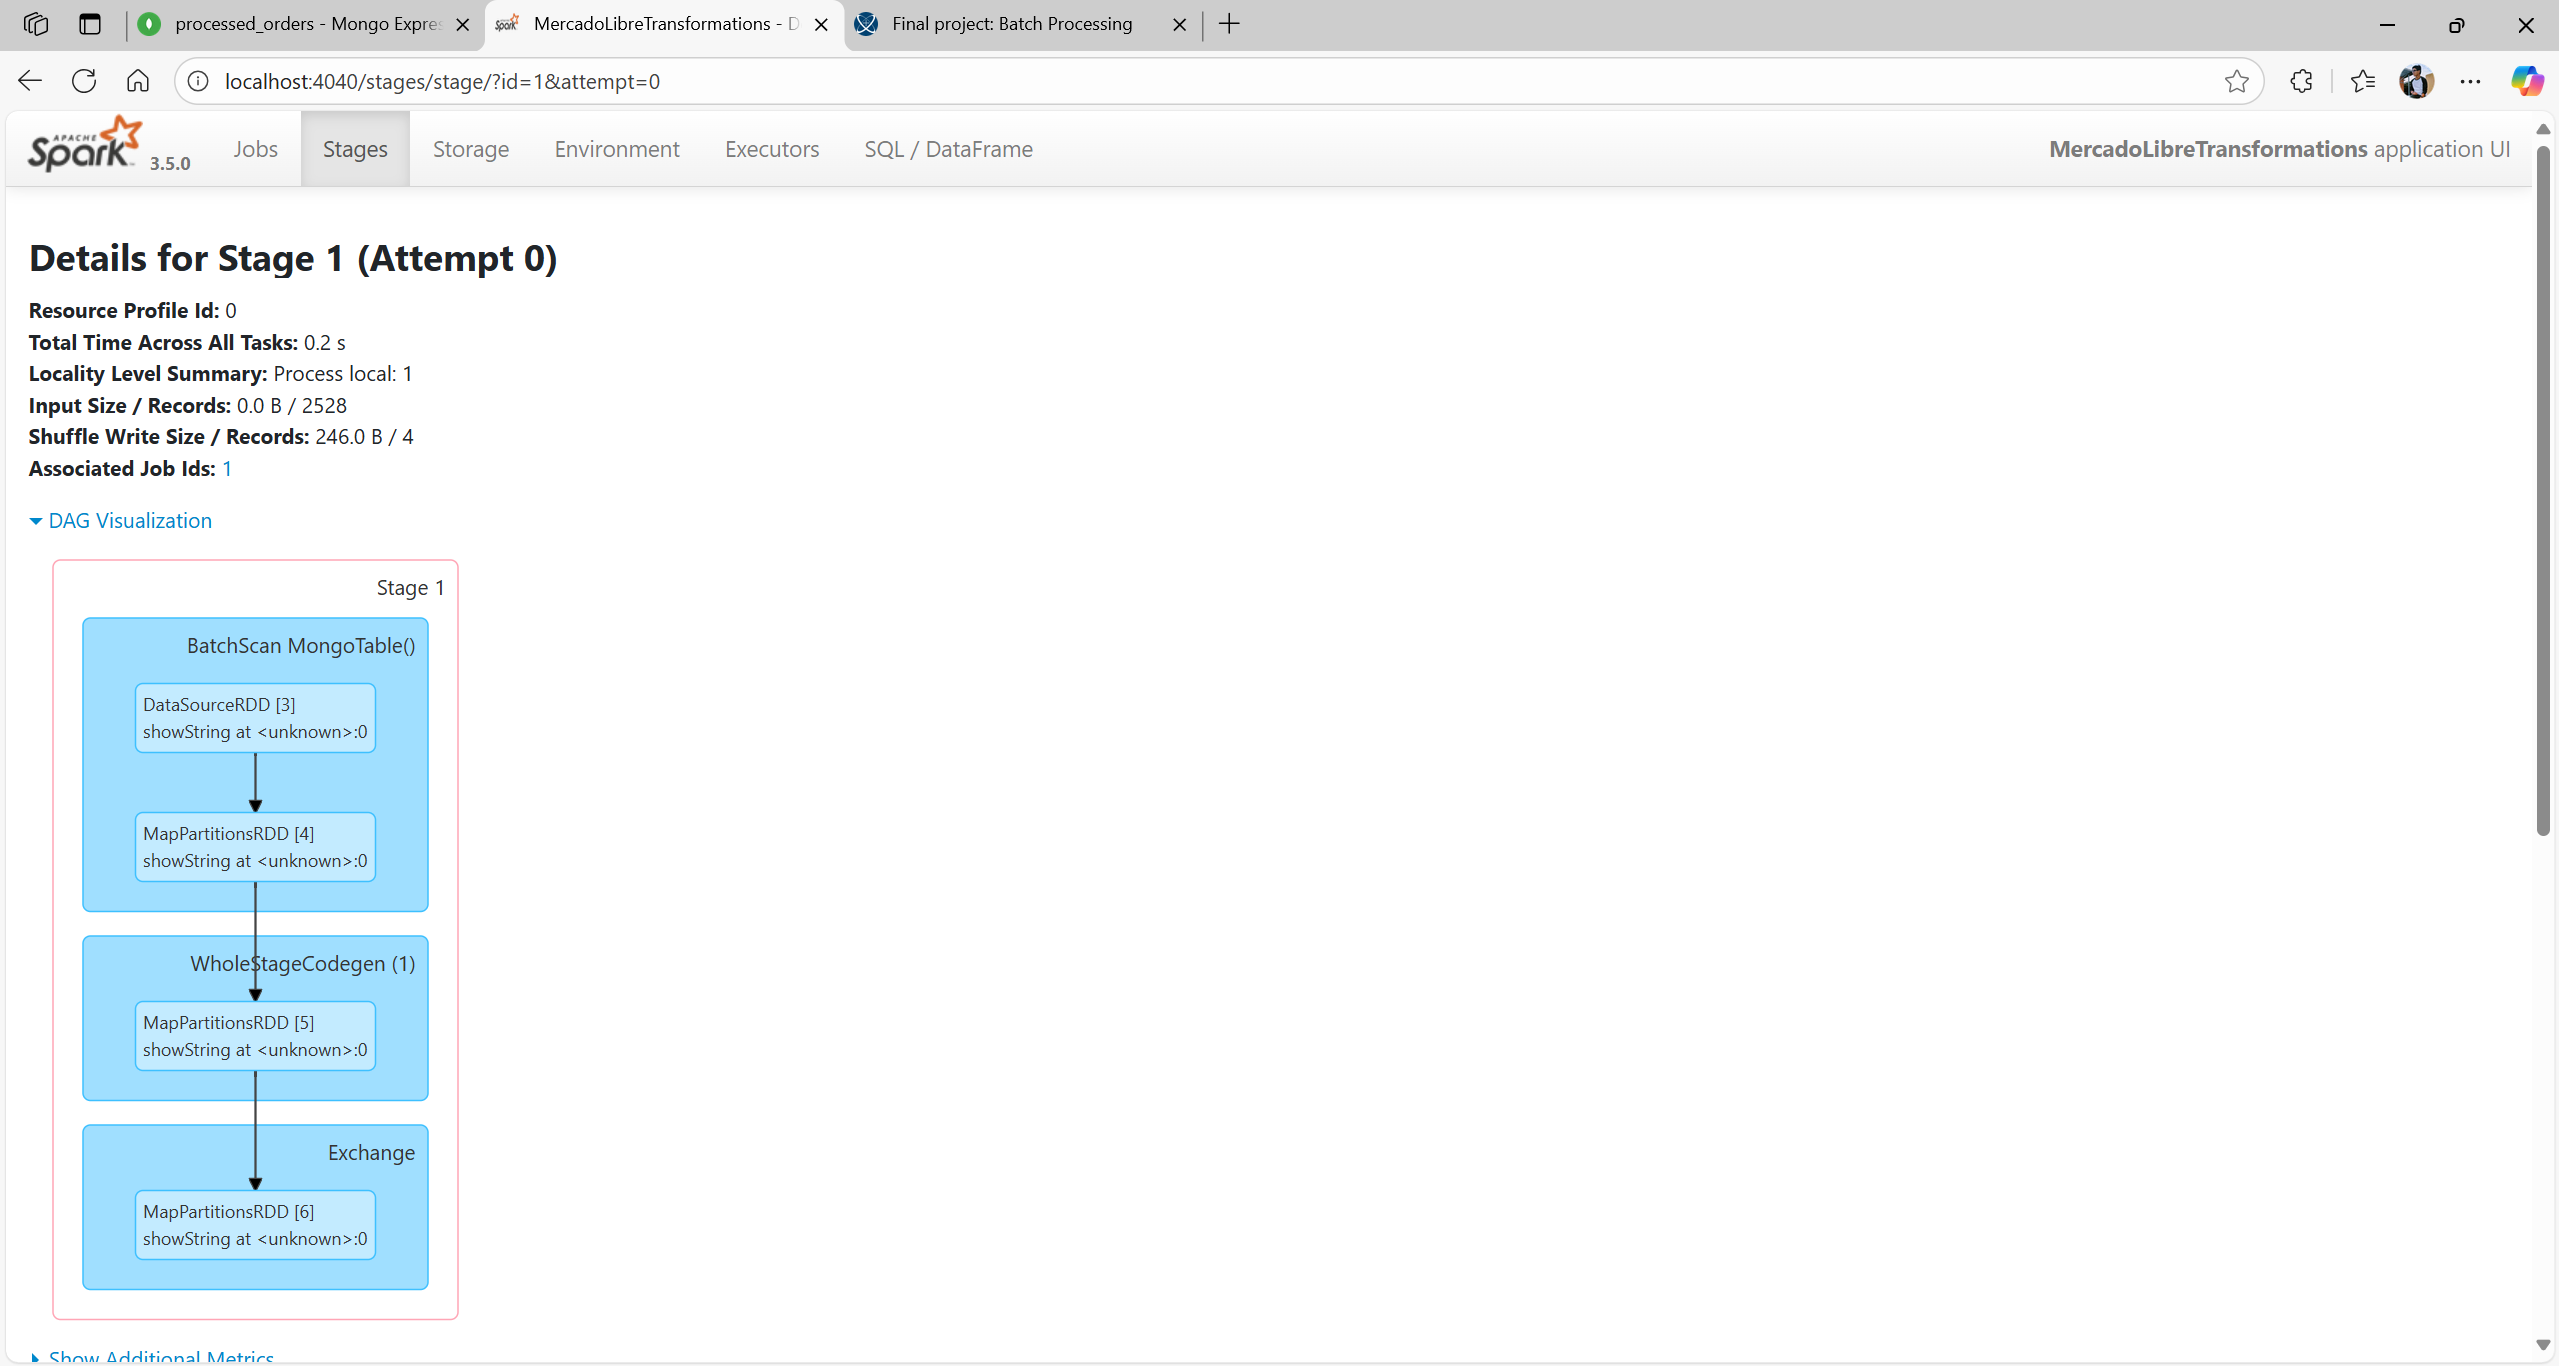